In [ ]:
pip install dwave-ocean-sdk

In [ ]:
pip install yahoo_fin

In [ ]:
pip install requests_html

In [ ]:
pip install scikit-optimize

In [ ]:
pip install bayesian-optimization


In [ ]:
## Importing previous data using Yahoo_fin library
import pandas as pd
from yahoo_fin.stock_info import get_data

# List of tickers
tickers = ['AMZN', 'GOOGL', 'AAPL', 'WMT']

# Empty DataFrame to store the data
stock_data = pd.DataFrame()

# Empty DataFrame to store the data for today's date
stock_data_T = pd.DataFrame()

# Fetching data for each ticker, with a mock start and end date

# Say start date- end date is a year

start_date = '2020-01-01'
end_date = '2020-12-31'
before_date = '2020-12-30'

for ticker in tickers:
  data = get_data(ticker, start_date=start_date, end_date=end_date)
  stock_data[ticker] = data['close'].dropna()

# Transposing the DataFrame to make tickers as rows and dates as columns
stock_data = stock_data.transpose()

# Replacing NaN values with 0
stock_data.fillna(0, inplace=True)

print(stock_data)

for ticker in tickers:
  data = get_data(ticker, start_date = before_date, end_date=end_date)
  stock_data_T[ticker] = data['close'].dropna()
# Transposing the DataFrame to make tickers as rows and dates as columns
stock_data_T = stock_data_T.transpose()

# Replacing NaN values with 0
stock_data_T.fillna(0, inplace=True)

print(stock_data_T)


       2020-01-02  2020-01-03  2020-01-06  2020-01-07  2020-01-08  2020-01-09  \
AMZN    94.900497   93.748497   95.143997   95.343002   94.598503   95.052498   
GOOGL   68.433998   68.075996   69.890503   69.755501   70.251999   70.989502   
AAPL    75.087502   74.357498   74.949997   74.597504   75.797501   77.407501   
WMT     39.646667   39.296665   39.216667   38.853333   38.720001   39.119999   

       2020-01-10  2020-01-13  2020-01-14  2020-01-15  ...  2020-12-16  \
AMZN    94.157997   94.565002   93.472000   93.100998  ...  162.048004   
GOOGL   71.447998   72.001503   71.529503   71.959999  ...   87.859497   
AAPL    77.582497   79.239998   78.169998   77.834999  ...  127.809998   
WMT     38.793331   38.626667   38.726665   38.426666  ...   48.476665   

       2020-12-17  2020-12-18  2020-12-21  2020-12-22  2020-12-23  2020-12-24  \
AMZN   161.804001  160.082504  160.309006  160.326004  159.263504  158.634506   
GOOGL   87.025497   86.310997   86.727997   86.011002   86.41

In [ ]:
##Creating Covariance Matrix from returns

import pandas as pd
import numpy as np


# Calculating covariance matrix of these returns
covariance_matrix = stock_data.transpose().cov().values

print(covariance_matrix)

[[744.28594939 176.74202751 545.89720206  93.85618395]
 [176.74202751  76.26219014 163.85105233  27.00508521]
 [545.89720206 163.85105233 471.98527892  76.11330555]
 [ 93.85618395  27.00508521  76.11330555  16.15562944]]


In [ ]:
##Creating mean returns matrix from Price matrix (stock_data)

# Calculate mean returns for each row
mean_returns = np.mean(stock_data, axis=1)

print(mean_returns)

AMZN     133.928454
GOOGL     73.895361
AAPL      95.198889
WMT       43.181204
dtype: float64


ADDING CONTROVERSY LEVEL?

In [ ]:
##Creating ESG matrix for each of the stock, putting in mock values(for now, need to create the ESG table as done in the iop pdf - need subscription access to bloomberg)

# Generate random ESG scores for each company
#esg_scores = np.random.randint(1, 11, size=len(stock_data))

#Using yahoo fin sustainibility as the criterion: out of 50
esg_scores = np.array([30.6,24.2,17.2,25.3]).transpose()

x = 1e-8

# Normalize the ESG scores between 0 and 1
normalized_esg_scores = esg_scores/ (50)

# Create a DataFrame for the normalized ESG scores with the same index as the stock data
esg_data = pd.DataFrame(normalized_esg_scores, columns=['Normalized_ESG_Score'], index=stock_data.index)

print(esg_data.values)

[[0.612]
 [0.484]
 [0.344]
 [0.506]]


In [ ]:
##Creating Priming functions to start with actual data, and using the above expression as the qubo

import numpy as np

def transform_price_vector(P, B):
    """
    Transform the price vector P to P' by dividing by the total budget B.
    Parameters:
    - P: Original price vector (numpy array)
    - B: Total budget (float)

    Returns:
    - P_prime: Transformed price vector (numpy array)
    """
    return P.values/ B

def transform_mean_vector(P_prime, mean_vector):
    """
    Transform the mean vector by element-wise multiplication with the transformed price vector.

    Parameters:
    - P_prime: Transformed price vector (numpy array)
    - mean_vector: Original mean vector (numpy array)

    Returns:
    - mean_prime: Transformed mean vector (numpy array)
    """
    return np.array(P_prime)* np.array(mean_vector)

def transform_covariance_matrix(P_prime, covariance_matrix):
    """
    Transform the covariance matrix using element-wise multiplication with the transformed price vector.

    Parameters:
    - P_prime: Transformed price vector (numpy array)
    - covariance_matrix: Original covariance matrix (numpy array)

    Returns:
    - covariance_prime: Transformed covariance matrix (numpy array)
    """
    covariance_prime = np.multiply(np.transpose(np.multiply(P_prime,covariance_matrix)), P_prime)
    return np.array(covariance_prime)




In [ ]:
## Quantum Formulation

## Creation of encoding matrix:

## Finding ni(max): Int(B/P_i) , and d_i = Int(log_2(ni^max)) ,ni - sum(j=0 to d_i)b_(i,j) , so now I must find d for each of the assets, to create the encoding matrix.

# Function to calculate the binarizing factor d for each row
def calculate_binarizing_factors(prices_row, B):
  binarizing_factors = []
  for prices in prices_row:
    max_prices = np.ceil(B / prices_row)
    binarizing_factors_row = np.ceil(np.log2(max_prices))
   # print("price: ", prices, " | ", binarizing_factors_row)
    binarizing_factors.append(binarizing_factors_row.astype(int)[0])
  return binarizing_factors

N = len(stock_data_T)
B=10000
binarizing_factors = calculate_binarizing_factors(stock_data_T.transpose().values, B)
binarizing_factors = binarizing_factors[0]

print(binarizing_factors)

# Initialize the encoding matrix C
N = len(stock_data_T)
#print("N:", N)
total_columns = np.sum(row_factors + 1 for row_factors in binarizing_factors)
#print("total_columns: ", total_columns)
C = np.zeros(N * (total_columns) )  # Initialize as an empty matrix
C = C.reshape(N, (total_columns))

#print("C: \n", C, "shape: ", np.shape(C))

# Populate the encoding matrix C
col_index = 0
#print("enumerate(binarizing_factors): ", binarizing_factors )

temp_sum = 0
for i in range(N):
    for k in range(binarizing_factors[i] + 1):
        C[i][temp_sum + k] = 2**k
    temp_sum += binarizing_factors[i] + 1

encoding_matrix = C

#for d_i in binarizing_factors:
#        submatrix = np.diag([2**j for j in range(d_i + 1)])
#        C[, col_index:col_index + d_i + 1] = submatrix[i]
#        col_index += d_i + 1

print("\nEncoding Matrix C:")
print(C)
C_transpose = np.transpose(C)

# Perform dot product
dot_product = np.dot(C, C_transpose)

print(dot_product)



[6 7 7 8]

Encoding Matrix C:
[[  1.   2.   4.   8.  16.  32.  64.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   2.   4.   8.  16.  32.  64.
  128.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   1.   2.   4.   8.  16.  32.  64. 128.   0.   0.   0.   0.   0.
    0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   2.   4.   8.  16.
   32.  64. 128. 256.]]
[[ 5461.     0.     0.     0.]
 [    0. 21845.     0.     0.]
 [    0.     0. 21845.     0.]
 [    0.     0.     0. 87381.]]


<ipython-input-35-ec860a87fa6b>:27: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_columns = np.sum(row_factors + 1 for row_factors in binarizing_factors)


In [ ]:
##Defining double prime vectors:

# Function to convert µ' to µ''
def convert_mu(mu_prime, encoding_matrix):
    return np.dot(encoding_matrix.T, mu_prime)

# Function to convert σ' to σ''
def convert_sigma(sigma_prime, encoding_matrix):
    return np.dot(np.dot(encoding_matrix.T, sigma_prime), encoding_matrix)

# Function to convert P' to P''
def convert_P(P_prime, encoding_matrix):
    return np.dot(encoding_matrix.T, P_prime)

In [ ]:
# Defining the various primed vectors and creating the QubO, say Budget is constrained to 10000
P_prime = transform_price_vector(stock_data_T , 10000)
P_prime = P_prime.reshape(4)
#print(P_prime)
#print(mean_returns.values)
mu_prime = transform_mean_vector(P_prime, mean_returns.values)
epsilon = 10000
theta_prime = esg_data.values
lambda_val = 10
q = 0.39
sigma_prime = transform_covariance_matrix(P_prime.transpose(), covariance_matrix)

#print(np.shape(mu_prime))

sigma_prime2 = convert_sigma(sigma_prime, encoding_matrix)
P_prime2 = convert_P(P_prime, encoding_matrix)
mu_prime2 = convert_mu(mu_prime, encoding_matrix)
theta_prime2 = convert_mu(theta_prime, encoding_matrix)

#print(P_prime2)
#print(mu_prime2)
#print(theta_prime2)
#print(sigma_prime2)

#print(np.shape(P_prime2))
#print(np.shape(mu_prime2))
#print(np.shape(theta_prime2))
#print(np.shape(sigma_prime2))


# Initialize the matrix dimensions based on the length of P_prime2
N = len(P_prime2)

# Construct the matrix
matrix = np.zeros((N, N))

# Fill in the diagonal elements
for i in range(N):
    matrix[i, i] = mu_prime2[i]  - lambda_val * (P_prime2[i]**2) + lambda_val* 2 * P_prime2[i]

# Fill in the off-diagonal elements
for i in range(N):
    for j in range(i + 1, N):
        matrix[i, j] = matrix[j, i] = -q * sigma_prime2[i, j] - lambda_val * P_prime2[i] * P_prime2[j]

print(matrix)



[[  2.52622978  -0.16209872  -0.32419745 ...  -0.23550702  -0.47101403
   -0.94202807]
 [ -0.16209872   5.04706116  -0.64839489 ...  -0.47101403  -0.94202807
   -1.88405613]
 [ -0.32419745  -0.64839489  10.07252871 ...  -0.94202807  -1.88405613
   -3.76811227]
 ...
 [ -0.23550702  -0.47101403  -0.94202807 ...  18.48744868  -3.08434987
   -6.16869974]
 [ -0.47101403  -0.94202807  -1.88405613 ...  -3.08434987  35.08273891
  -12.33739948]
 [ -0.94202807  -1.88405613  -3.76811227 ...  -6.16869974 -12.33739948
   62.59684403]]


Transformation of QUBO to Ising





In [ ]:
import dimod


Q = matrix
# Create a BinaryQuadraticModel from the QUBO
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)

# Convert the BQM to an Ising model
h_m, J_m, offset = bqm.to_ising()

# Number of spins (adjust based on your actual problem size)
num_spins = len(h_m)

# Create a vector for h
h= np.zeros(num_spins)
for i in range(num_spins):
  h[i] = h_m[i]

# Create a matrix for J, ensure it is symmetric
J = np.zeros((num_spins, num_spins))
for (i, j), value in J_m.items():
    J[i, j] = value
    J[j, i] = value  # This makes the matrix symmetric

# Print the matrices
print("h vector:")
print(h)
print("\nJ matrix:")
print(J)

print("Ising biases (h):", h)
print("Ising couplings (J):", J)
print("Constant offset:", offset)

h vector:
[-1.24620908e+01 -2.48458314e+01 -4.93782621e+01 -9.75029216e+01
 -1.89991433e+02 -3.59925225e+02 -6.39619888e+02 -2.00072826e+00
 -3.99921503e+00 -7.98946406e+00 -1.59430642e+01 -3.17426724e+01
 -6.29115213e+01 -1.23527748e+02 -2.37874320e+02 -8.49286993e+00
 -1.69528255e+01 -3.37739934e+01 -6.70213565e+01 -1.31936192e+02
 -2.55446301e+02 -4.77188266e+02 -8.19559193e+02 -6.12356877e-01
 -1.22456822e+00 -2.44855432e+00 -4.89478014e+00 -9.78024629e+00
 -1.95232366e+01 -3.88974492e+01 -7.71988028e+01 -1.52013223e+02]

J matrix:
[[ 0.         -0.08104936 -0.16209872 ... -0.11775351 -0.23550702
  -0.47101403]
 [-0.08104936  0.         -0.32419745 ... -0.23550702 -0.47101403
  -0.94202807]
 [-0.16209872 -0.32419745  0.         ... -0.47101403 -0.94202807
  -1.88405613]
 ...
 [-0.11775351 -0.23550702 -0.47101403 ...  0.         -1.54217493
  -3.08434987]
 [-0.23550702 -0.47101403 -0.94202807 ... -1.54217493  0.
  -6.16869974]
 [-0.47101403 -0.94202807 -1.88405613 ... -3.08434987 -6

Implementing Bayesian Optimization to find values of Alpha and Beta:

Using Poor Man's Ising machine's function "fun" as the "error" to calculate alpha and beta, as done in the code described, as the objective to minimize, we can create bayesian optimization code to find optimal values of alpha and beta.

Link to PMIM code: https://colab.research.google.com/drive/1jqfN187CTEjdPYqZQHU8M9KuCFKFk7dA#scrollTo=-yrmPqpL6i89

In [ ]:
#def coupling_matrix(N, h):
#    J = np.zeros((N, N))
#    for i in range(N):
#        J[i, i] = h/2
#        if i > 0:
#            J[i, i-1] = 1
#    J = J + np.transpose(J)

    #return J

def definitions(N, Tmax):
    # N is the total number of spins
    # Tmax is the total number of evolutions

    x = np.zeros((N, Tmax))   #the value of the voltages
    f = np.zeros((N, Tmax))   #the function f
    g = np.random.normal(0, 0.02, size=(N, Tmax)) #gaussian noise

    # all the above three arrays have been defined such that
    # the second dimension corresponds to different number of evolutions
    # the first dimension includes different spins

    h = 0
    # h is the uniform external magnetic field to be used in the Hamiltonian

    Ja = J
    return x, f, g, Ja

def voltage(alpha, beta, N, Tmax, x, f, g, J):
    for k in range(Tmax-1):
        for n in range(N):
            sum1 = 0
            if beta != 0:
                for j in range(N):
                    sum1 += J[j, n]*x[j, k]
            f[n, k] = alpha*x[n, k] + beta*sum1                              #equation 3.2 in the paper with beta=0
            x[n, k+1] = (np.cos(f[n, k] + g[n, k] - np.pi/4))**2 - 0.5       #equation 3.1 in the paper
    return x

Using the bayesian optimization from PMIM

<ipython-input-39-35fc74e383ab>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[n, k] = alpha*x[n, k] + beta*sum1                              #equation 3.2 in the paper with beta=0
<ipython-input-39-35fc74e383ab>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[n, k] = alpha*x[n, k] + beta*sum1                              #equation 3.2 in the paper with beta=0
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a bett

Best Beta for Alpha =  1.0 is 1.6


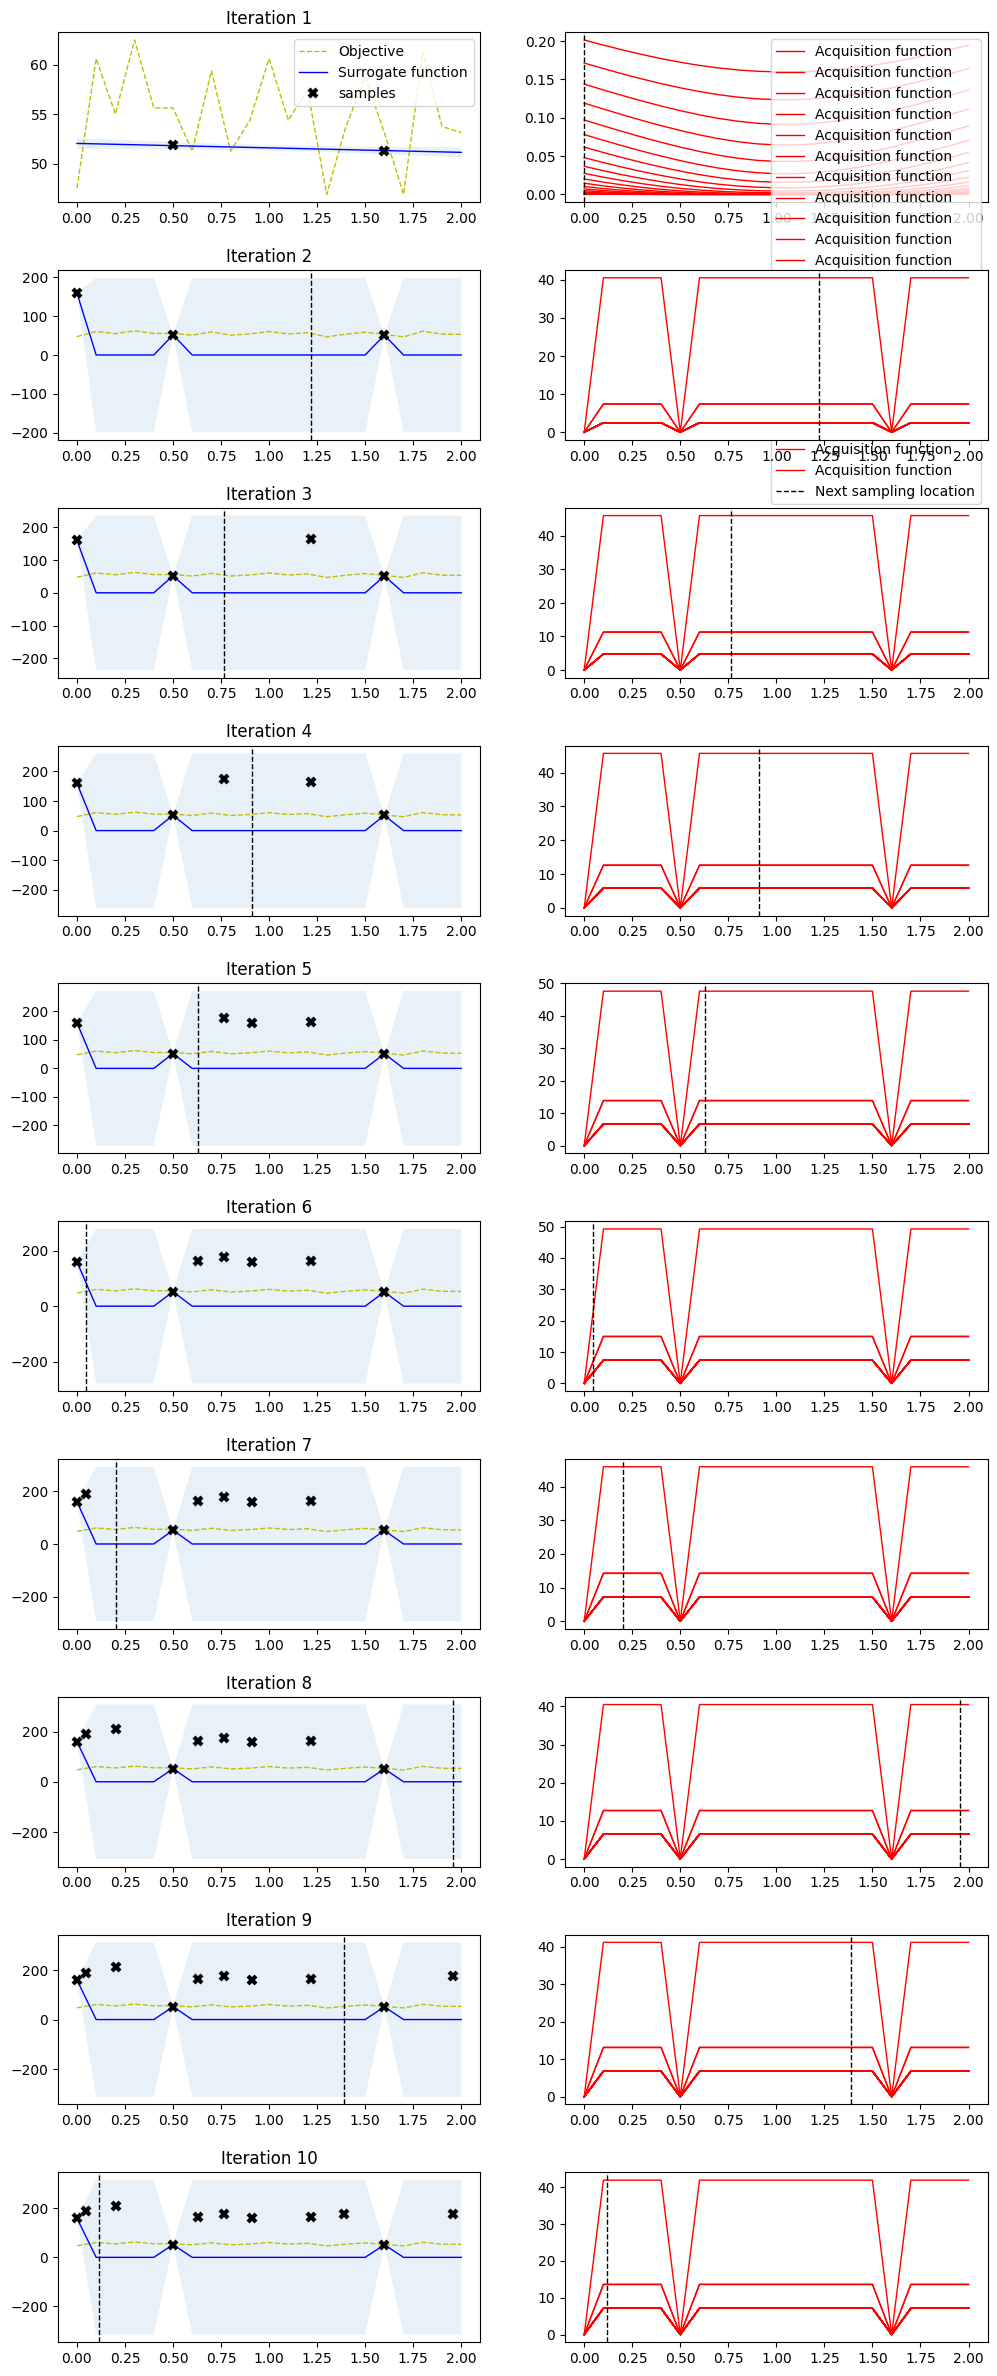

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

def fun(alpha, beta):
    N = 32
    Tmax = 32
    flag = 0
    y = np.zeros(1)

    for k in range(5):
        x, f, g, J = definitions(N, Tmax)
        x = voltage(alpha, beta, N, Tmax, x, f, g, J)
        if x[0,-1] > 0:
            flag = 1

        for i in range(1,N,1):
            if J[i-1, i] < 0:
                if x[i, -1] > 0:
                    if flag == 1:
                        y[0] += 1
                    flag = 1
                else:
                    if flag == -1:
                        y[0] += 1
                    flag = -1
            if J[i-1, i] > 0:
                if x[i, -1] > 0:
                    if flag == -1:
                        y[0] += 1
                    flag = 1
                else:
                    if flag == 1:
                        y[0] += 1
                    flag = -1
    y /= 0.05*N
    return y

N = 32
Tmax = 32
flag = 0
X = np.linspace(0,2,21) # beta values
X = X.reshape(-1,1)
Z = np.linspace(1,3,21) # alpha values
Y = np.zeros(21)
Y = Y.reshape(-1,1)

for i in range(21):
    Y[i] = fun(Z[0], X[i])

X_init = np.array([[0.5], [1.6]])
Y_init = np.zeros(2)
Y_init = Y_init.reshape(-1, 1)

Y_init[0] = fun(Z[0], X_init[0])
Y_init[1] = fun(Z[0], X_init[1])

bounds = np.array([[0, 2.0]])
noise = 0.2

def expected_improvement(X, X_sample, Y_smaple, gpr, xi=0.01):
  mu, sigma = gpr.predict(X, return_std=True)
  mu_sample = gpr.predict(X_sample)

  sigma = sigma.reshape(-1, 1)
  mu_sample_opt = np.max(Y_sample)

  with np.errstate(divide='warn'):
      for i in range(len(sigma)):
          if sigma[i] == 0.0: ei[i] = 0.0
          else:
              imp = mu - mu_sample_opt - xi
              Z1 = imp / sigma
              ei = imp * norm.cdf(Z1) + sigma * norm.pdf(Z1)

  return ei

from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

    # Finding the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(-1, 1)

def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(),
                     mu.ravel() + 1.96 * std,
                     mu.ravel() - 1.96 * std,
                     alpha=0.1)
    plt.plot(X, Y, 'y--', lw=1, label='Objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)


X_sample = X_init
Y_sample = Y_init


n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
        # Updating Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtaining next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)

        # Obtaining next noisy sample from the objective function
    Y_next = fun(Z[0], X_next)*100/N

        # Plotting samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X.reshape(-1,1), Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X.reshape(-1,1), X_sample, Y_sample, gpr), X_next, show_legend=i==0)


    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))


print("Best Beta for Alpha = " ,Z[0],  "is" ,X_sample[np.argmin(Y_sample), 0])


# To vary alpha as well, making another code

Function values at each step of the optimization: [47.5   47.5   43.125 48.75  43.75  58.125 53.125 50.    48.75  53.125
 53.125 48.75  48.75  51.25  48.75  55.625 55.625 48.125 52.5   48.125
 51.25  38.125 48.75  54.375 43.75  50.625 51.875 50.625 50.625 53.125
 45.625 48.75  45.    50.    50.625 49.375 36.875 47.5   44.375 49.375
 48.125 51.25  40.625 47.5   45.    50.    43.75  45.    48.75  45.
 61.875 60.625 56.875 46.25  51.25  61.25  63.125 50.    48.75  41.875
 49.375 51.875 53.125 48.75  52.5   48.75  45.    46.25  45.    58.75
 40.    53.75  37.5   50.625 46.25  40.625 48.75  48.125 47.5   52.5  ]


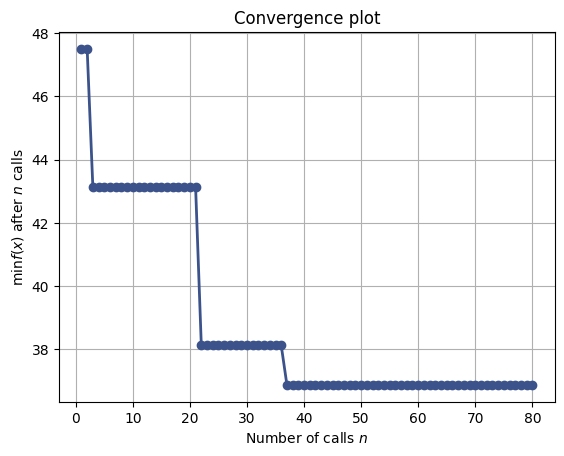

<Figure size 1200x800 with 0 Axes>

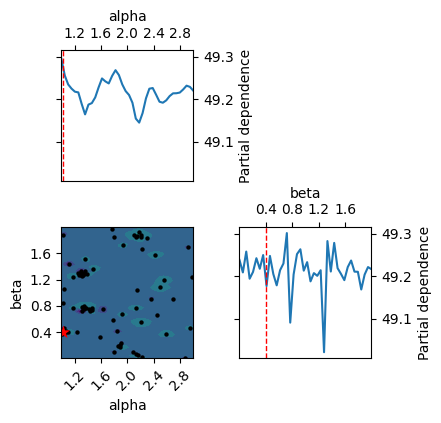

Best alpha: 1.028159645430169
Best beta: 0.3976848081776104


In [ ]:
from skopt import gp_minimize
from skopt.space import Real
from skopt.plots import plot_convergence, plot_objective
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor

# Defining the function accepting a list [alpha, beta] (for gp.minimize to work)
def fun(both):
    alpha, beta = both
    N = 32
    Tmax = 32
    flag = 0
    y = np.zeros(1)

    for k in range(5):
        x, f, g, J = definitions(N, Tmax)
        x = voltage(alpha, beta, N, Tmax, x, f, g, J)
        for i in range(N):
            if x[i, -1] > 0:
                if (i > 0 and J[i-1, i] < 0) or (i < N-1 and J[i+1, i] < 0):
                    if flag == 1:
                        y[0] += 1
                    flag = 1
                else:
                    if flag == -1:
                        y[0] += 1
                    flag = -1

    return y[0] / (0.05 * N)  # Ensuring scalar


# Defining the bounds for alpha and beta
dimensions = [
    Real(1, 3, name="alpha"),
    Real(0, 2, name="beta")
]

# Performing Bayesian Optimization
result = gp_minimize(
    fun,
    dimensions=dimensions,
    acq_func="LCB",
    kappa=10,
    n_calls=80,
    n_initial_points=40,
    random_state=42
)


function_values = result.func_vals

print("Function values at each step of the optimization:", function_values)

# Plotting convergence of the acquisition function
plot_convergence(result)

# Plotting the objective landscape
fig = plt.figure(figsize=(12, 8))
plot_objective(result, dimensions=["alpha", "beta"])
plt.show()

# Best alpha and beta values
print("Best alpha:", result.x[0])
print("Best beta:", result.x[1])


In [ ]:
from dwave.cloud import Client
from dwave.system import DWaveSampler, EmbeddingComposite
import numpy as np

client = Client.from_config(token='UcZ6-34eb2cff48608374528cdcb08d02e3c0757b6f89')

sampler = DWaveSampler(token='UcZ6-34eb2cff48608374528cdcb08d02e3c0757b6f89')

# Wrapping the sampler with EmbeddingComposite for better performance
embedding_sampler = EmbeddingComposite(sampler)


In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite
import numpy as np

def get_ising_model(alpha, beta):
    # Updating Ising model parameters based on alpha and beta
    J_updated = alpha * J + beta  # Adjusting J based on alpha and beta
    h_updated = beta * h          # Adjusting h based on beta

    return J_updated, h_updated


# Setting alpha and beta values
alpha = result.x[0]
beta = result.x[1]

# Updated parameters
J_updated, h_updated = get_ising_model(alpha, beta)

# Using QPU
response = embedding_sampler.sample_ising(h_updated, J_updated, num_reads=100)

# Processing results
for sample in response.data(['sample', 'energy']):
    print(sample, "Energy: ", sample.energy)


Sample(sample={0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: -1, 8: -1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: -1, 24: -1, 25: -1, 26: -1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1}, energy=-5929.662873418331) Energy:  -5929.662873418331
Sample(sample={0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: -1, 8: -1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: -1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: -1, 24: -1, 25: -1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1}, energy=-5913.8122565156) Energy:  -5913.8122565156
Sample(sample={0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: -1, 8: 1, 9: -1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: -1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: -1, 24: -1, 25: 1, 26: -1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1}, energy=-5876.688971662575) Energy:  -5876.688971662575
Sample(sample={0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: -1, 8: -1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: -1, 17: 

In [ ]:
import numpy as np

# Initializing lists to store final samples and energies
final_samples = []
final_energies = []

# Processing results
for sample in response.data(['sample', 'energy']):
    # Changing -1 to 0 and 1 to 1
    final_sample = [1 if value == 1 else 0 for value in sample.sample.values()]
    final_samples.append(final_sample)
    final_energies.append(sample.energy)

# Print only the final set of values
print("Final Samples:", final_samples[-1])
b= final_samples[-1]

# Obtained the binarized target vector b and have the encoding matrix C

# Reverse transformation to get the continuous vector
P_final = np.linalg.inv(dot_product) @ np.dot(C,b)*B

P = P_final
tickers = ['AMZN', 'GOOGL', 'AAPL', 'WMT']
print("Final Recommendation:", P)

Final Samples: [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]
Final Recommendation: [232.55813953 100.70954452 114.90043488  45.89098317]


Backtesting

[*********************100%%**********************]  4 of 4 completed


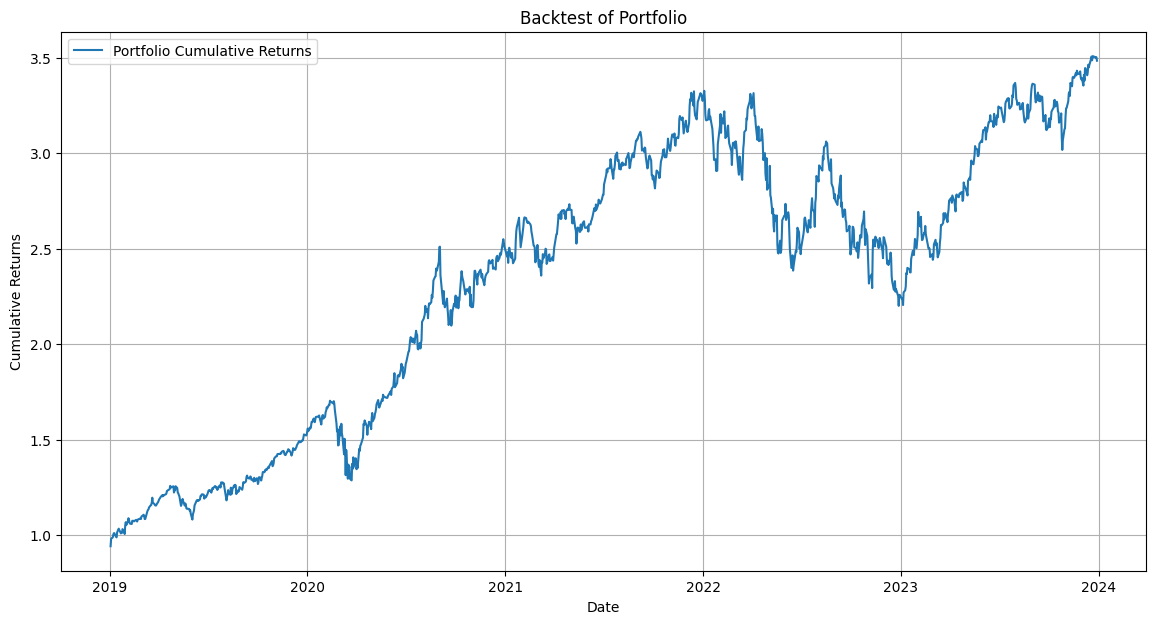

Final Cumulative Return: 3.49
Annualized Return: 28.43%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Define the tickers and optimal weights from the optimization
tickers = ['AAPL', 'WMT', 'AMZN', 'GOOGL']
weights = np.array([230.72697308,  98.87846189, 113.98489357,  55.38961559])  # Final weights

# Normalize weights
weights /= np.sum(weights)

# Download historical data for the tickers
start_date = '2019-01-01'
end_date = '2024-01-01'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculating daily returns
returns = data.pct_change().dropna()

# Calculating portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

# Calculating cumulative returns for the portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Portfolio Cumulative Returns')
plt.title('Backtest of Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Final cumulative return
final_cumulative_return = cumulative_returns.iloc[-1]
print(f"Final Cumulative Return: {final_cumulative_return:.2f}")

# Annualized return
days = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days
annualized_return = (final_cumulative_return ** (365/days)) - 1
print(f"Annualized Return: {annualized_return:.2%}")


[*********************100%%**********************]  4 of 4 completed


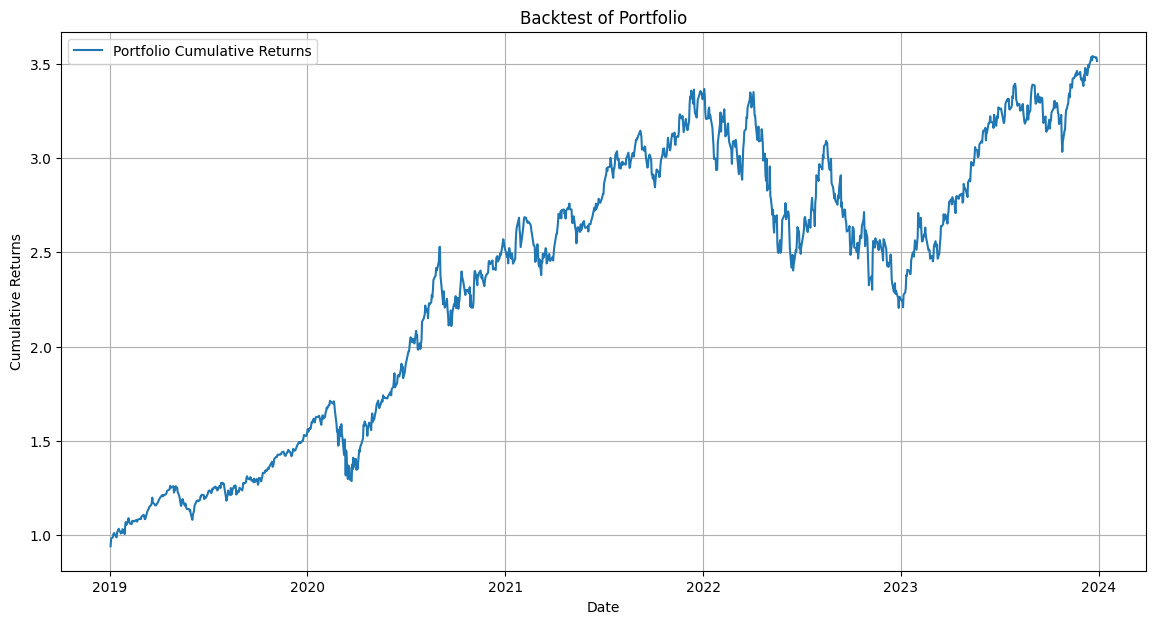

Final Cumulative Return: 3.52
Annualized Return: 28.66%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Define the tickers and optimal weights from the optimization
tickers = ['AAPL', 'WMT', 'AMZN', 'GOOGL']
weights = np.array([232.55813953, 100.70954452, 114.90043488,  45.89098317])  # Final weights

# Normalize weights
weights /= np.sum(weights)

# Download historical data for the tickers
start_date = '2019-01-01'
end_date = '2024-01-01'
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Calculating daily returns
returns = data.pct_change().dropna()

# Calculating portfolio returns
portfolio_returns = (returns * weights).sum(axis=1)

# Calculating cumulative returns for the portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(cumulative_returns, label='Portfolio Cumulative Returns')
plt.title('Backtest of Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

# Final cumulative return
final_cumulative_return = cumulative_returns.iloc[-1]
print(f"Final Cumulative Return: {final_cumulative_return:.2f}")

# Annualized return
days = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days
annualized_return = (final_cumulative_return ** (365/days)) - 1
print(f"Annualized Return: {annualized_return:.2%}")


In [ ]:
# Construct the matrix
matrix = np.zeros((N, N))

# Fill in the diagonal elements
for i in range(N):
    matrix[i, i] = mu_prime2[i]  - lambda_val * (P_prime2[i]**2) + 2 * P_prime2[i]

# Fill in the off-diagonal elements
for i in range(N):
    for j in range(i + 1, N):
        matrix[i, j] = matrix[j, i] = -q * sigma_prime2[i, j] - lambda_val * P_prime2[i] * P_prime2[j]

print(matrix)

[[  2.23050329  -0.16209872  -0.32419745 ...  -0.23550702  -0.47101403
   -0.94202807]
 [ -0.16209872   4.45560818  -0.64839489 ...  -0.47101403  -0.94202807
   -1.88405613]
 [ -0.32419745  -0.64839489   8.88962274 ...  -0.94202807  -1.88405613
   -3.76811227]
 ...
 [ -0.23550702  -0.47101403  -0.94202807 ...  12.95093652  -3.08434987
   -6.16869974]
 [ -0.47101403  -0.94202807  -1.88405613 ...  -3.08434987  24.0097146
  -12.33739948]
 [ -0.94202807  -1.88405613  -3.76811227 ...  -6.16869974 -12.33739948
   40.4507954 ]]
